Nome: Henrique Rodrigues Martins Fonntes \
Matícula: 14728901

# 1) Como os dados devem ser preparados para o processamento?

Primeiro verifiremos se há dados ausentes ou dados erroneamente colocados.

In [1]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import colors as mcolors
import scipy.cluster.hierarchy as shc
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

In [2]:
df = pd.read_csv('C:\\Users\\Henrique\\trab 1 IA\\Stars1.csv') #lê a tabela de dados

def tabela(dados):  #Formata a tabela
    df_styled = dados.style.set_table_styles([{'selector': 'th', 'props': 'text-align: center;'},  {'selector': 'td', 'props': 'text-align: center;'} ])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df_styled)
        
tabela(df)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.170000,16.120000,Red,M,0
1,3042,0.000500,0.154200,16.600000,Red,M,0
2,2600,0.000300,0.102000,18.700000,Red,M,0
3,2800,0.000200,0.160000,16.650000,Red,M,0
4,1939,0.000138,0.103000,20.060000,Red,M,0
5,2840,0.000650,0.110000,16.980000,Red,M,0
6,2637,0.000730,0.127000,17.220000,Red,M,0
7,2600,0.000400,0.096000,17.400000,Red,M,0
8,2650,0.000690,0.110000,17.450000,Red,M,0
9,2700,0.000180,0.130000,16.050000,Red,M,0


Como podemos ver, na tabela "Color", temos alguns dados redundantes, como "White" e "white". Iremos ajustador esses dados padronizando eles:

In [3]:
dicionário_de_substituição = { #Define um dicionário com as modificaçoes que quero
    'Blue White': 'Blue-White',
    'Blue white': 'Blue-White',
    'Blue-white': 'Blue-White',
    'Pale yellow orange': 'Pale-Yellow-Orange',
    'white': 'White',
    'Whitish': 'Whiteish',
    'yellowish': 'Yellowish',
    'Yellowish White': 'Yellowish-White',
    'yellow-white': 'Yellow-White',
}

df['Color'] = df['Color'].replace(dicionário_de_substituição) #Substitui os dados com as modificações feitas
tabela(df)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.170000,16.120000,Red,M,0
1,3042,0.000500,0.154200,16.600000,Red,M,0
2,2600,0.000300,0.102000,18.700000,Red,M,0
3,2800,0.000200,0.160000,16.650000,Red,M,0
4,1939,0.000138,0.103000,20.060000,Red,M,0
5,2840,0.000650,0.110000,16.980000,Red,M,0
6,2637,0.000730,0.127000,17.220000,Red,M,0
7,2600,0.000400,0.096000,17.400000,Red,M,0
8,2650,0.000690,0.110000,17.450000,Red,M,0
9,2700,0.000180,0.130000,16.050000,Red,M,0


Em seguida vamos codificar os dados que são categóricos, como Color, Spectral_Class e Type: (estou codificando a coluna Type porque por mais que sejam números, "type" não é uma grandeza, mas sim um label)

In [4]:
encoder = OneHotEncoder(sparse_output=False) # Não sei o porque de ter que definir sparse_output=False, mas sem isso da um erro de diferença de tamanho entre matrizes.
encoder.fit(df[['Color','Spectral_Class','Type']]) #Ajusta o OneHotEncoder para as colunas que quero
one_hot_encoded = encoder.transform(df[['Color','Spectral_Class','Type']]) #transforma as colunas que quero
df_codificado = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Color','Spectral_Class','Type'])) #Gera uma tabela com os dados transformados
df_codificado_original = df.join(df_codificado) #Inclui a tabela dos dados transformados na tabela de dados original
df_novo = df_codificado_original.drop(columns=['Color','Spectral_Class','Type']) #Remove as colunas 'Color','Spectral_Class' e 'Type' da tabela original
tabela(df_novo)

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale-Yellow-Orange,Color_Red,Color_White,Color_White-Yellow,Color_Whiteish,Color_Yellow-White,Color_Yellowish,Color_Yellowish-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O,Type_0,Type_1,Type_2,Type_3,Type_4,Type_5
0,3068,0.002400,0.170000,16.120000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3042,0.000500,0.154200,16.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2600,0.000300,0.102000,18.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2800,0.000200,0.160000,16.650000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1939,0.000138,0.103000,20.060000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2840,0.000650,0.110000,16.980000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2637,0.000730,0.127000,17.220000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2600,0.000400,0.096000,17.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2650,0.000690,0.110000,17.450000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2700,0.000180,0.130000,16.050000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Agora, como podemos perceber, os valores nas colunas têm diferentes ordens de magnitude. Portanto, iremos reescalonar esses dados.

# 2) Quais as variáveis devem ser reescalonadas e por qual método?

As variáveis que devem ser reescalonadas são "Temperature", "L", "R" e "A_M", pois as ordens de magnitude entre essas variáveis diverge muito.

Primeiro, iremos análisar a distribuição de frequência dos valores dessas variáveis:

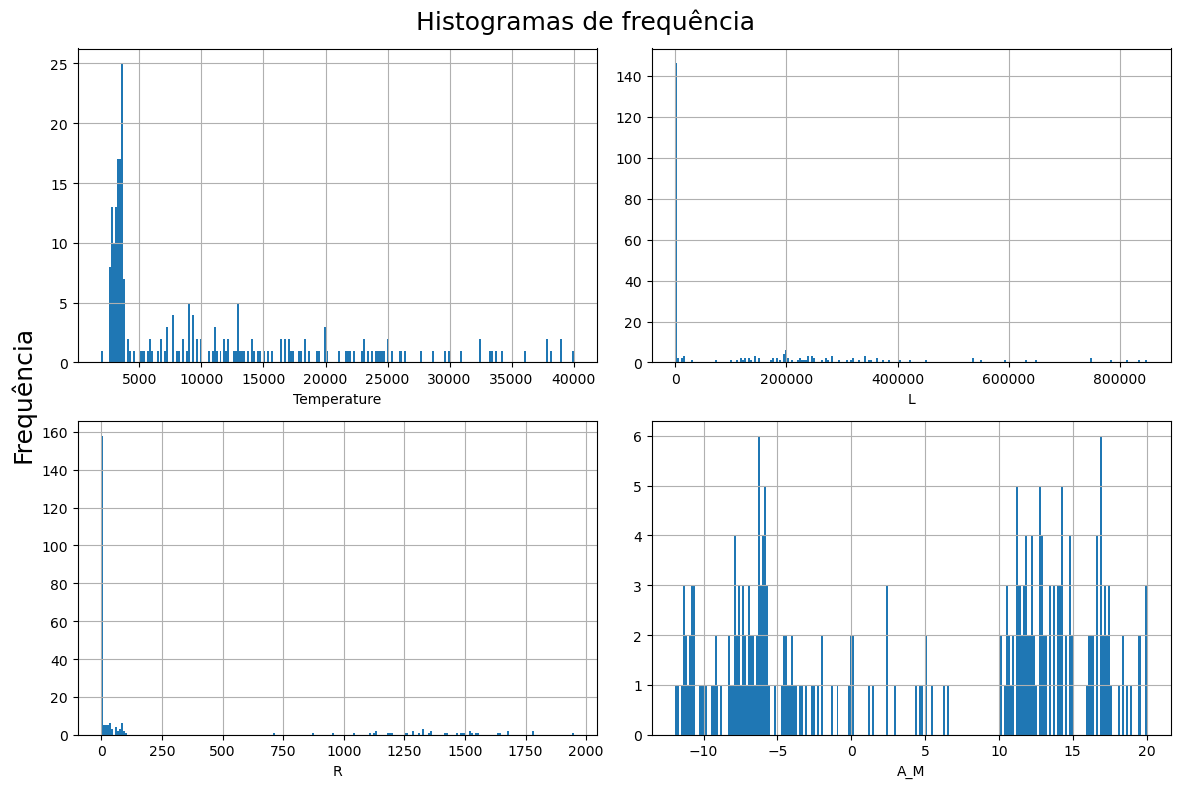

In [5]:
fig,a = plt.subplots(2,2,figsize=(12, 8))
a = a.ravel()

fig.suptitle('Histogramas de frequência', wrap=True,fontsize=18)
fig.supylabel("Frequência",fontsize=18)

T = df_novo['Temperature']
L = df_novo['L']
R = df_novo['R']
A_M = df_novo['A_M']

data = [T,L,R,A_M]
data_name = ['Temperature', 'L', 'R', 'A_M']

for i,ax in enumerate(a):
    
    ax.hist(data[i],bins=240) #Para aglomerar mais os valores no histograma, basta diminuir o valor de bins
    ax.set_xlabel(data_name[i])
    ax.grid()
plt.tight_layout()

Como os histogramas de "Temperature", "L" e "R" apresentam uma estrutura de "heavy tail", o que podemos fazer é transformas os valores dessas variáveis para escala logarítimica para a tentar deixar o mais simétrico possível e diminuir a calda. Como o histograma de "A_M" é mais ou menos simétrico, não precisamos fazer isso.

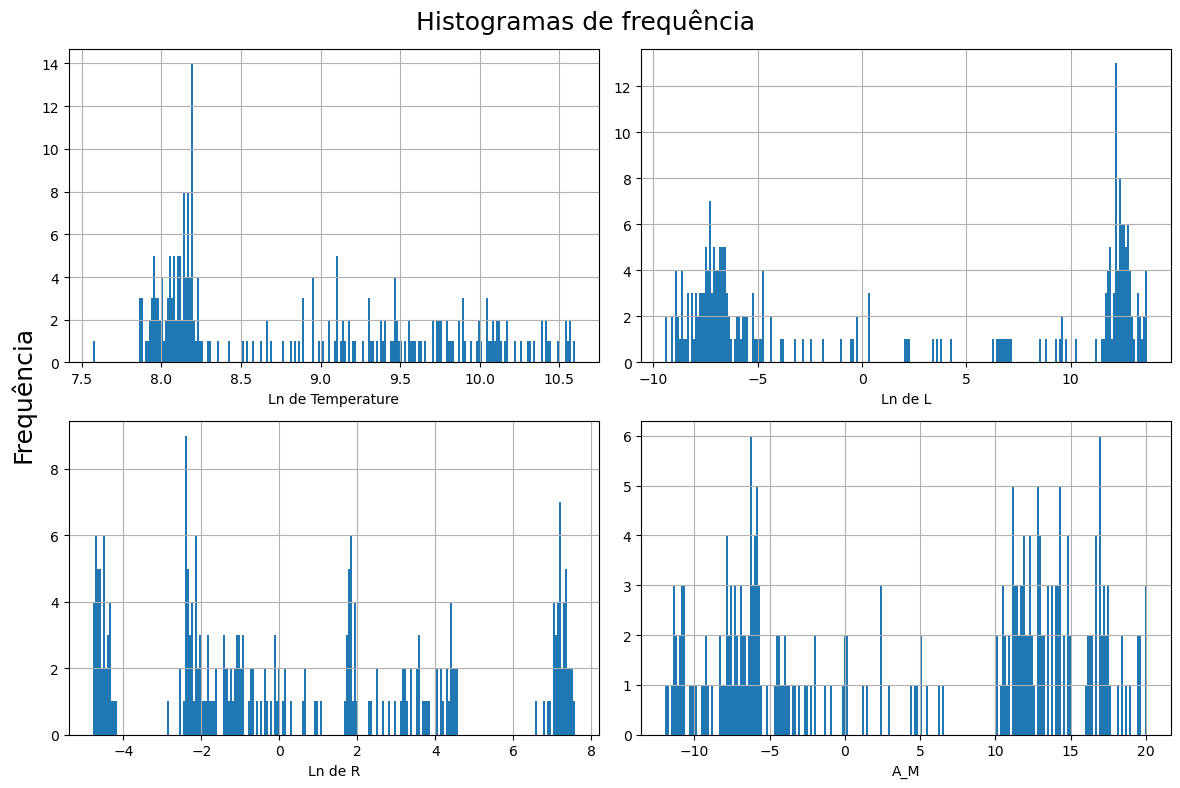

In [6]:
fig,a = plt.subplots(2,2,figsize=(12, 8))
a = a.ravel()

fig.suptitle('Histogramas de frequência', wrap=True,fontsize=18)
fig.supylabel("Frequência",fontsize=18)

T = df_novo['Temperature']
L = df_novo['L']
R = df_novo['R']
A_M = df_novo['A_M']

data = [T,L,R,A_M]
data_name = ['Temperature', 'L', 'R', 'A_M']

for i,ax in enumerate(a):
    if i == 3: 
        ax.hist(data[i],bins=240)
        ax.set_xlabel(data_name[i])
        ax.grid()
        
    else:
        ax.hist(np.log(data[i]),bins=240)
        ax.set_xlabel('Ln de %s' %data_name[i])
        ax.grid()
plt.tight_layout()

df_novo['Temperature'] = np.log(df_novo['Temperature'])
df_novo['L']= np.log(df_novo['L'])
df_novo['R']= np.log(df_novo['R'])

Mesmo nos dados originais, vimos que os mesmos não apresentam um distribuição normal, logo não seria interessante aplicar uma transformação como o StandardScalar. Contudo, com os dados de "Temperature", "L" e "R" em escala logarítmica, vemos que os dados não possuem uma discrepância muito grande de valores e a estrutura de "heavy tail" foi diminuída. Portanto, parece interessante aplicar o método de normalização MinMaxScalar, já que neste conjunto de dados modificados, o método não irá "apertar" 
a maioria dos valores em um pequen intervalo.

Além disso, o método MinMaxScalar preserva a relação com os dados originais enquanto normaliza eles.

Normalizando os  de "Temperature", "L", "R" e "A_M", temos:

In [7]:
scaler = MinMaxScaler()
df_novo['Temperature'] = scaler.fit_transform(df_novo[['Temperature']])
df_novo['L']= scaler.fit_transform(df_novo[['L']])
df_novo['R']= scaler.fit_transform(df_novo[['R']])
df_novo['A_M']= scaler.fit_transform(df_novo[['A_M']])

tabela(df_novo)

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale-Yellow-Orange,Color_Red,Color_White,Color_White-Yellow,Color_Whiteish,Color_Yellow-White,Color_Yellowish,Color_Yellowish-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O,Type_0,Type_1,Type_2,Type_3,Type_4,Type_5
0,0.151602,0.147329,0.243442,0.876798,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.148790,0.079381,0.235546,0.891807,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.096917,0.057254,0.202094,0.957473,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.121402,0.039691,0.238535,0.893371,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.023617,0.202884,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.126088,0.090746,0.208206,0.903690,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.101585,0.095774,0.219838,0.911194,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.096917,0.069716,0.197187,0.916823,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.103210,0.093333,0.208206,0.918386,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.109386,0.035127,0.221728,0.874609,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 3) Aplique a redução de variáveis pelo método PCA e determine o número de componentes necessárias para se explicar, pelo menos, 90% da variância dos dados.

90% dos dados são explicados com as 8 componentes.


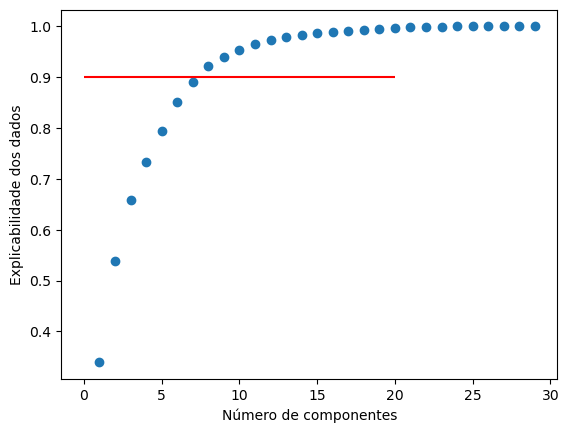

In [8]:
pca = PCA()
pca.fit(df_novo)
explainability = pca.explained_variance_ratio_.cumsum()
factors = np.arange(1,df_novo.shape[1]+1,1)
plt.scatter(factors,explainability)
plt.hlines(0.9,0,20,'r')
plt.xlabel('Número de componentes')
plt.ylabel('Explicabilidade dos dados')

p = factors[explainability<0.9].max()+1

if p<2:
    p=2
    
print('90% dos dados são explicados com as ' + str(p) + ' componentes.')

pca = PCA(n_components=p)
pca.fit(df_novo)
df_pca = pca.transform(df_novo)

Com isto temos que precisamos de 8 componentess para explicar, pelo menos, 90% da variância dos dados.

# 4) Olhando as três primeiras componentes principais do PCA, quais a variáveis da tabela são mais importantes para o agrupamento dos dados?

Primeiro, vamos gerar uma tebela que mostra os coeficientes de cada variável para cada componente:

In [9]:
Matriz_de_componentes= pca.components_ # matriz onde as linhas são as componentes e as colunas são as variáveis. Os valores são os coeficientes, ou peso, de cada variável.

tres_primeiras_componentes = Matriz_de_componentes[:3] # seleciona apenas as três primeiras componentes principais

tabela_coeficientes = pd.DataFrame(tres_primeiras_componentes, columns=df_novo.columns) #renomea as colunas com os nomes das variáveis

tabela(tabela_coeficientes)

,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale-Yellow-Orange,Color_Red,Color_White,Color_White-Yellow,Color_Whiteish,Color_Yellow-White,Color_Yellowish,Color_Yellowish-White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O,Type_0,Type_1,Type_2,Type_3,Type_4,Type_5
0,0.270368,0.251585,0.113205,-0.216013,0.289726,0.144074,0.002754,0.001685,0.000738,-0.483232,0.014435,0.000791,0.005435,0.016120,0.004642,0.002831,0.047832,0.172041,0.024591,0.000456,0.009208,-0.483815,0.229686,-0.220787,-0.204792,0.088839,0.141085,0.162427,0.033227
1,0.056817,-0.380552,-0.358040,0.291704,-0.167004,0.245300,-0.011085,0.002742,0.008334,-0.218222,0.062553,0.008183,0.006759,0.028059,0.009047,0.025332,0.096421,0.278582,0.104867,-0.006287,0.000620,-0.211850,-0.262352,0.036025,-0.011347,0.367606,0.124214,-0.268776,-0.247723
2,-0.033205,0.224675,0.245932,-0.223274,-0.439037,0.360382,0.020405,0.004024,-0.005639,0.044504,-0.017493,-0.005495,0.012549,0.031401,0.011648,-0.017250,0.113716,0.148525,-0.020029,0.010125,0.036609,0.033847,-0.322794,-0.138244,-0.062088,-0.159502,0.288221,-0.306888,0.378502


Agora vamos criar uma lista que organiza os valores de cada linha do maior para o menor, em magnitude. Além disso, ao invés da lista conter os valores em si, vamos fazer com que a lista tenha os nomes das variáveis que correspondam a estes valores. Com isto, teremos uma lista que nos diz, da esquerda para a direita, quais as variáveis mais importantes para cada componente.

In [10]:
listas_colunas=[]
for i in range(0,3):
    linha = tabela_coeficientes.iloc[i] #seleciona a linha
    organizado = linha.abs().sort_values(ascending=False) # Organiza a linha com os valores absolutos do maior para o menor
    lista_colunas = organizado.index.to_list() # Troca os valores pelo nome da coluna correspondente
    listas_colunas.append(lista_colunas)
    
    print("Variáveis mais importantes, da esquerda para a direita, para a componente %.0f:" %(i+1), lista_colunas)
    print()

Variáveis mais importantes, da esquerda para a direita, para a componente 1: ['Spectral_Class_M', 'Color_Red', 'Color_Blue', 'Temperature', 'L', 'Spectral_Class_O', 'Type_0', 'A_M', 'Type_1', 'Spectral_Class_B', 'Type_4', 'Color_Blue-White', 'Type_3', 'R', 'Type_2', 'Spectral_Class_A', 'Type_5', 'Spectral_Class_F', 'Color_Yellow-White', 'Color_White', 'Spectral_Class_K', 'Color_Whiteish', 'Color_Yellowish', 'Color_Yellowish-White', 'Color_Orange', 'Color_Orange-Red', 'Color_White-Yellow', 'Color_Pale-Yellow-Orange', 'Spectral_Class_G']

Variáveis mais importantes, da esquerda para a direita, para a componente 2: ['L', 'Type_2', 'R', 'A_M', 'Spectral_Class_B', 'Type_4', 'Spectral_Class_O', 'Type_5', 'Color_Blue-White', 'Color_Red', 'Spectral_Class_M', 'Color_Blue', 'Type_3', 'Spectral_Class_F', 'Spectral_Class_A', 'Color_White', 'Temperature', 'Type_0', 'Color_Yellow-White', 'Color_Yellowish-White', 'Type_1', 'Color_Orange', 'Color_Yellowish', 'Color_Pale-Yellow-Orange', 'Color_White-Ye

Levando em consideração que, nestas listas, a posição de uma variável é o fator mais relevante, i.e. posições com valores pequenos (quanto menor, mais a esquerda) são os mais imporantes, posso criar uma unica lista que mostra as variáveis mais relevantes considerando as 3 listas.

Posso fazer isso calculando a soma das posições das variável em cada lista. Valores com menor soma são mais relevantes, pois eles estão mais para esquerda considerando todas as listas originais.

In [11]:
def posição(lista, variável): # obtem a posição de um valor (variável) em uma lista. A posição do valor é seu índice na lista + 1
    return lista.index(variável) + 1

soma_posicoes = [] 

for variável in set(listas_colunas[0] + listas_colunas[1] + listas_colunas[2]):
    soma_posicoes0 = ( posição(listas_colunas[0], variável) + posição(listas_colunas[1], variável) + posição(listas_colunas[2], variável) ) # irá somar as posições de uma variável em cada lista

    soma_posicoes.append((soma_posicoes0, variável)) 

soma_posicoes.sort() # ordena os valores das somas de posiçoes do menor para o maior, como consequencia ele ordena as tuplas com base na ordenação dos valores da soma.

lista_relevancia = [variável[1] for variável in soma_posicoes] #cria uma lista apenas com as variáveis. Esta lista ja esta organizada por culpa da linha acima.

print("Variáveis mais importantes, da esquerda para a direita, para o agrupamento dos dados:", lista_relevancia)

Variáveis mais importantes, da esquerda para a direita, para o agrupamento dos dados: ['L', 'Color_Blue', 'Spectral_Class_O', 'A_M', 'Type_4', 'Color_Blue-White', 'R', 'Spectral_Class_B', 'Color_Red', 'Type_2', 'Type_5', 'Spectral_Class_M', 'Type_3', 'Type_0', 'Temperature', 'Spectral_Class_A', 'Type_1', 'Spectral_Class_F', 'Color_Yellow-White', 'Color_White', 'Spectral_Class_K', 'Color_Orange', 'Color_Yellowish-White', 'Color_Yellowish', 'Color_Whiteish', 'Color_Pale-Yellow-Orange', 'Color_White-Yellow', 'Spectral_Class_G', 'Color_Orange-Red']


Com isto, temos que, por exmplo, as três variáveis mais relevantes para o agrupamento dos dados são: L, Color_Blue e Spectral_Class_O. Já as três variáveis menos relevantes são: Color_White-Yellow, Spectral_Class_G e Color_Orange-Red.

# 5) Utilize o método de agrupamento hierárquico para agrupar as estrelas de acordo com suas características. Qual o número de agrupamentos ideal para análise desses dados?

Usando os dados com dimensão reduzida via PCA, temos:

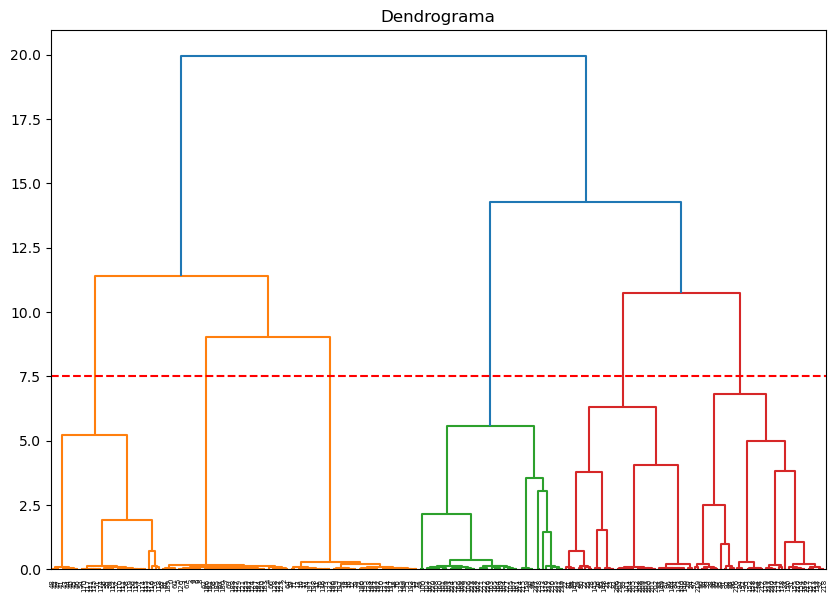

In [12]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograma")
clusters = shc.linkage(df_pca, method='ward', metric="euclidean")
shc.dendrogram(Z=clusters)
altura_corte = 7.5
plt.axhline(y=altura_corte, color='r', linestyle='--')
plt.show()

Com base numa análise visual, um corte na altura 7.5, determinando 6 grupos, parece ser uma quantidade razoável de clusters. 

#  6) Utilize o método KMeans para agrupar as estrelas de acordo com suas características. Qual o  número de agrupamentos ideal para análise desses dados?

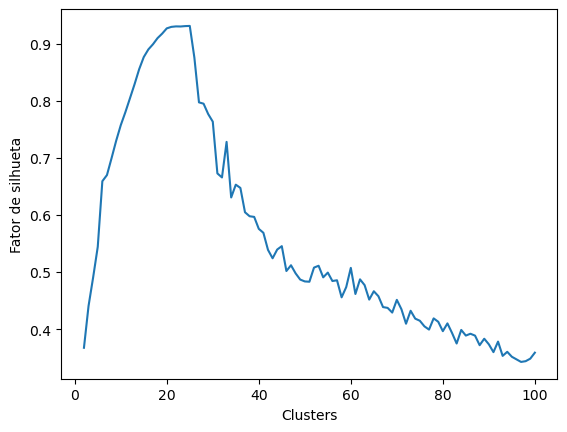

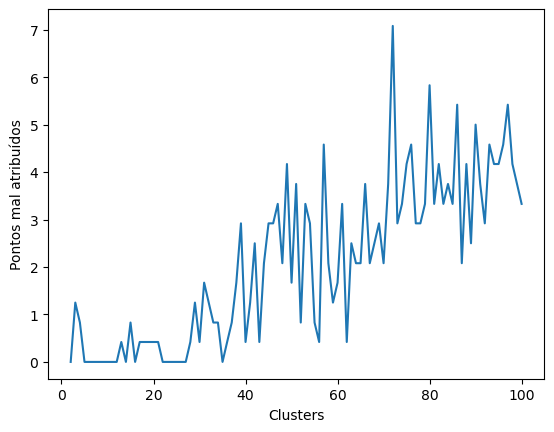

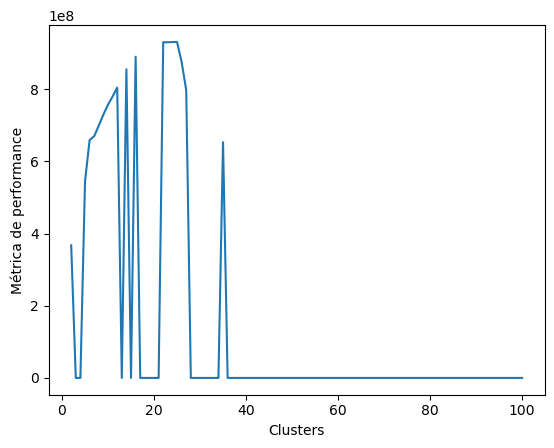

In [13]:
Ns = np.asarray(list(range(2, 101)))
silhueta_scores = np.zeros(len(Ns))
pontos_bad = np.zeros(len(Ns))

for i,N in enumerate(Ns):
    kmeans = KMeans(n_clusters=N).fit(df_pca)
    categorias = kmeans.labels_
    silhueta_scores[i] = silhouette_score(df_pca, categorias)
    sample_silhouette_values = silhouette_samples(df_pca, categorias)
    mask = ( sample_silhouette_values < 0 )
    pontos_bad[i] = 10**-9 if (100 * mask.sum() / len(mask)).round(2)==0 else (100 * mask.sum() / len(mask)).round(2)
    
        
plt.plot(Ns,silhueta_scores);
plt.xlabel('Clusters')
plt.ylabel('Fator de silhueta')

plt.figure()
plt.plot(Ns,pontos_bad)
plt.xlabel('Clusters')
plt.ylabel('Pontos mal atribuídos')

plt.figure()
plt.plot(Ns,silhueta_scores/pontos_bad)
plt.xlabel('Clusters')
plt.ylabel('Métrica de performance')

opt_n_clusters = Ns[(silhueta_scores/pontos_bad).argmax()]

In [14]:
print("número de agrupamentos ideal para análise desses dados usando o KMeans:", opt_n_clusters )

número de agrupamentos ideal para análise desses dados usando o KMeans: 25


Para fins de vizualização, irei plotar o gráfico componente 1 vs componente 2 usando 25 clusters

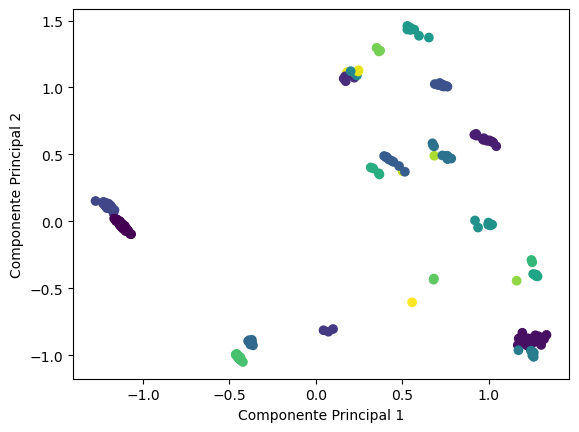

In [15]:
kmeans = KMeans(n_clusters=opt_n_clusters).fit(df_pca)
categorias = kmeans.labels_

plt.figure()
plt.scatter(df_pca[:,0], df_pca[:,1], c=categorias)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2');

# 7) Utilize o método DBSCAN para agrupar as estrelas de acordo com suas caraterísticas. Qual o número de agrupamentos obtido? Comente sobre a presença ou não de outliers

In [16]:
@widgets.interact(epsilon=(0, 10, 0.01), minN=(1,400))

def dbscan(epsilon = 0.32, minN = 6):
    dbscan = DBSCAN(eps=epsilon, min_samples=minN).fit(np.array([df_pca[:,0], df_pca[:,1]]).T)
    categorias = dbscan.labels_
    plt.scatter(df_pca[:,0], df_pca[:,1], c=categorias)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2');
    plt.text(-1,1.5,str((categorias == -1).sum())+' Outliers')
    plt.text(-1,1.25,str(categorias.max())+' Agrupamentos')
    plt.show()
    plt.clf() # Limpa os eixos
    plt.cla() # Limpa a figura
    plt.close() # Fecha o gráfico

interactive(children=(FloatSlider(value=0.32, description='epsilon', max=10.0, step=0.01), IntSlider(value=6, …

# 8) Faça uma análise sobre a performance geral dos algoritmos utilizados nos itens de 5 a 7.

No geral, o método de agrupamento hierárquico é uma abordagem um tanto quanto subjetiva pra determinar o número de cluster. Este método mostrou todos os possíveis agrupamentos, mas não parece que há um teste quantitativo para ser aplicado sobre ele pra determinar uma quantidade de grupos.\
\
Já o KMeans é um método que da pra submeter a um teste, como o de silhueta. Fazendo tal, o algorítimo encontrou que são necessários 25 cluster para descrever bem os dados. O que parece um tanto quanto sem lógico, visto que sabemos que este dados abrange 7 tipos de estrelas. Contudo, acredito que esta quantidade de cluester é devido a alta dimensionalidade mesmo após aplicar o PCA. Acredito que se determinar as colunas Color e Spectral_class em forma de números baseando-se na temperatura, já que as 3 quantidades estão fortemente correlacionadas, e mantendo a coluna Type do jeito que está, manteremos 7 dimensões e ao aplicar o PCA será reduzido para poucas dimensão e provavelmente o KMeans irá exibir um comportamento mais esperado.
Já.\
\
O DBSCAN performou bem quando comparado ao KMeans, pois como este permite outliers, ficou fácil de determinar 7 grupos com pouquísssimos outliers. Contudo esta análise foi feita com o scatter das componentes que carregam a maior variancia, mas apenas essas duas não descrevem 90% dos dados.